In [1]:
import tensorflow as tf
from tensorflow import keras

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from cleverhans.attacks import FastGradientMethod
from cleverhans.compat import flags
from cleverhans.dataset import MNIST
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model
from cleverhans.utils_keras import KerasModelWrapper

from cleverhans.attacks import FastGradientMethod
from cleverhans.augmentation import random_horizontal_flip, random_shift
from cleverhans.compat import flags
from cleverhans.dataset import CIFAR10
from cleverhans.loss import CrossEntropy
from cleverhans.model_zoo.all_convolutional import ModelAllConvolutional
from cleverhans.train import train
from cleverhans.utils import AccuracyReport, set_log_level
from cleverhans.utils_tf import model_eval
import logging

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import sys
sys.path.append('..')
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
import matplotlib.pyplot as plt
import model_symmetries as vsf
%matplotlib inline

from skmultiflow.drift_detection.adwin import ADWIN
from scipy.stats import percentileofscore

import streaming_sim_test as sst
from importlib import reload

import colorama
from colorama import Fore, Style

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Input, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

from art.attacks import DeepFool, CarliniL2Method
from art.classifiers import KerasClassifier
from art.utils import load_dataset
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Mnist

### fgsm

In [4]:
def get_adversarial_acc_metric(model, fgsm, fgsm_params):
  def adv_acc(y, _):
    # Generate adversarial examples
    x_adv = fgsm.generate(model.input, **fgsm_params)
    # Consider the attack to be constant
    x_adv = tf.stop_gradient(x_adv)

    # Accuracy on the adversarial examples
    preds_adv = model(x_adv)
    return keras.metrics.categorical_accuracy(y, preds_adv)

  return adv_acc

In [5]:
train_start=0
train_end=60000
test_start=0
test_end=10000
nb_epochs=50
batch_size=128
learning_rate=0.001
testing=False
label_smoothing=0.1
fashion=False

In [6]:
report = AccuracyReport()

  # Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
  # Force TensorFlow to use single thread to improve reproducibility
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                          inter_op_parallelism_threads=1)


sess = tf.Session(config=config)
keras.backend.set_session(sess)

  # Get MNIST test data
    
if fashion:
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    np.random.seed(0)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    X_train = np.reshape(X_train, X_train.shape + (1,))
    X_test = np.reshape(X_test, X_test.shape + (1,))
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
else:
    mnist = MNIST(train_start=train_start, train_end=train_end,
                test_start=test_start, test_end=test_end)
    X_train, y_train = mnist.get_set('train')
    X_test, y_test = mnist.get_set('test')

  # Obtain Image Parameters
img_rows, img_cols, nchannels = X_train.shape[1:4]
nb_classes = y_train.shape[1]

  # Label smoothing
y_train -= label_smoothing * (y_train - 1. / nb_classes)

print('x_train shape:', X_train.shape, 'x_test shape:', X_test.shape)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)
  # Define Keras model
model = cnn_model(img_rows=img_rows, img_cols=img_cols,
                    channels=nchannels, nb_filters=64,
                    nb_classes=nb_classes)
print("Defined Keras model.")

  # To be able to call the model in the custom loss, we need to call it once
  # before, see https://github.com/tensorflow/tensorflow/issues/23769
model(model.input)

  # Initialize the Fast Gradient Sign Method (FGSM) attack object
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
                 'clip_min': 0.,
                 'clip_max': 1.}

adv_acc_metric = get_adversarial_acc_metric(model, fgsm, fgsm_params)
model.compile(
      optimizer=keras.optimizers.Adam(learning_rate),
      loss='categorical_crossentropy',
      metrics=['accuracy', adv_acc_metric]
  )

Traceback (most recent call last):
  File "/home/Gigio/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-bb0446ec7ade>", line 28, in <module>
    test_start=test_start, test_end=test_end)
  File "/home/Gigio/git/fork-cleverhans/cleverhans/dataset.py", line 98, in __init__
    test_end=test_end)
  File "/home/Gigio/git/fork-cleverhans/cleverhans/dataset.py", line 248, in data_mnist
    'train-images-idx3-ubyte.gz', datadir=datadir) / 255.
  File "/home/Gigio/git/fork-cleverhans/cleverhans/dataset.py", line 189, in download_and_parse_mnist_file
    file_name = maybe_download_file(url, datadir=datadir, force=force)
  File "/home/Gigio/git/fork-cleverhans/cleverhans/dataset.py", line 183, in maybe_download_file
    urlretrieve(url, dest_file)
  File "/home/Gigio/anaconda3/lib/python3.6/urllib/request.py", line 277, in urlretrieve
    block = fp.read(bs)
  File "/home

KeyboardInterrupt: 

In [7]:
model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=nb_epochs,
            validation_data=(X_test, y_test),
            verbose=1)


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 25s 412us/step - loss: 0.6539 - acc: 0.9570 - adv_acc: 0.0323 - val_loss: 0.1597 - val_acc: 0.9887 - val_adv_acc: 0.0271
Epoch 2/50
60000/60000 [==============================] - 5s 90us/step - loss: 0.5478 - acc: 0.9903 - adv_acc: 0.0311 - val_loss: 0.1198 - val_acc: 0.9907 - val_adv_acc: 0.0411
Epoch 3/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.5325 - acc: 0.9940 - adv_acc: 0.0361 - val_loss: 0.1228 - val_acc: 0.9922 - val_adv_acc: 0.0374
Epoch 4/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.5243 - acc: 0.9967 - adv_acc: 0.0463 - val_loss: 0.1178 - val_acc: 0.9928 - val_adv_acc: 0.0517
Epoch 5/50
60000/60000 [==============================] - 5s 90us/step - loss: 0.5182 - acc: 0.9982 - adv_acc: 0.0535 - val_loss: 0.1292 - val_acc: 0.9928 - val_adv_acc: 0.0627
Epoch 6/50
60000/60000 [==============================] - 5s 90

Epoch 47/50
60000/60000 [==============================] - 5s 90us/step - loss: 0.5038 - acc: 0.9998 - adv_acc: 0.2495 - val_loss: 0.1156 - val_acc: 0.9931 - val_adv_acc: 0.2552
Epoch 48/50
60000/60000 [==============================] - 5s 90us/step - loss: 0.5018 - acc: 1.0000 - adv_acc: 0.2467 - val_loss: 0.1185 - val_acc: 0.9938 - val_adv_acc: 0.2425
Epoch 49/50
60000/60000 [==============================] - 5s 90us/step - loss: 0.5010 - acc: 1.0000 - adv_acc: 0.2416 - val_loss: 0.1199 - val_acc: 0.9936 - val_adv_acc: 0.2407
Epoch 50/50
60000/60000 [==============================] - 5s 90us/step - loss: 0.5007 - acc: 1.0000 - adv_acc: 0.2430 - val_loss: 0.1203 - val_acc: 0.9942 - val_adv_acc: 0.2392


In [13]:
X_adv = sess.run(fgsm.generate(model.input, **fgsm_params), feed_dict={model.input: X_test})
y_adv = y_test

/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max at 0x7f65c280e2f0> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f65c2807a60> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "


Sample instance from the MNIST data set.


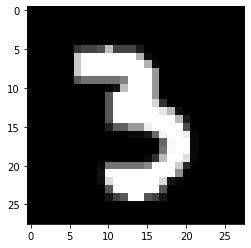

In [14]:
idx = 1042
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

Sample instance from the MNIST data set.


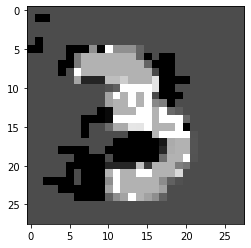

In [15]:
xa = X_adv[idx: idx + 1]
plt.imshow(np.squeeze(xa), 'gray')
print('Sample instance from the MNIST data set.')

In [16]:
model.predict(x)

array([[0.01065586, 0.00981614, 0.0099453 , 0.9086883 , 0.00963173,
        0.0103775 , 0.01086726, 0.01015184, 0.00998621, 0.00987992]],
      dtype=float32)

In [17]:
model.predict(xa)

array([[0.06406422, 0.05928265, 0.10232635, 0.1505784 , 0.0725035 ,
        0.21147744, 0.07278844, 0.0732244 , 0.12505664, 0.06869797]],
      dtype=float32)

In [26]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [27]:
vae = vsf.VaeSymmetryFinderConv(model, input_shape=(28, 28, 1), rgb_filters=1,
                            output_shape=(10, ), nb_conv_layers=2, lr=0.001,
                            intermediate_dim=256, variational=True, opt='RMSprop',
                            latent_dim=8, loss_type='symm', add_latent_loss=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 14, 14, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 7, 7, 128)    73856       dropout_13[0][0]                 
__________________________________________________________________________________________________
dropout_14

### Deep fool / Carlini

In [4]:
def prepare_data_mnist(fashion=False):
    
    if fashion:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    print('x_train shape:', X_train.shape, 'y_train shape:', y_train.shape)

    # define train and test set
    np.random.seed(0)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    X_train = np.reshape(X_train, X_train.shape + (1,))
    X_test = np.reshape(X_test, X_test.shape + (1,))
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

        
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

    return X_train, y_train, X_test, y_test
    

In [5]:
def model_mnist_keras(nb_classes=10):
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes, name='logits')(x)
    x_out = Activation('softmax', name='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [6]:
X_train, y_train, X_test, y_test = prepare_data_mnist(fashion=False)
X_test, y_test = X_test[:500], y_test[:500]
min_, max_ = X_train.min(), X_train.max()

x_train shape: (60000, 28, 28) y_train shape: (60000,)
(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)


Sample instance from the MNIST data set.


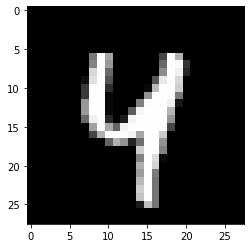

In [7]:
idx = 42
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

In [8]:
m = model_mnist_keras()
model = KerasClassifier(model=m, clip_values=(min_, max_))
model.fit(X_train, y_train, nb_epochs=10, batch_size=128)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch 1/10
469/468 [==============================] - 4s 10ms/step - loss: 0.3883 - acc: 0.8777
Epoch 2/10
469/468 [==============================] - 3s 5ms/step - loss: 0.1348 - acc: 0.9576
Epoch 3/10
469/468 [==============================] - 3s 5ms/step - loss: 0.1013 - acc: 0.9681
Epoch 4/10
469/468 [==============================] - 3s 5ms/step - loss: 0.0878 - acc: 0.9717
Epoch 5/10
469/468 [==============================] - 3s 5ms/step - loss: 0.0728 - acc: 0.9771
Epoch 6/10
469/468 [==============================] - 3s 5ms/step - loss: 0.0645 - acc: 0.9791
Epoch 7/10
469/468 [==============================] - 3s 5ms/step - loss: 0.0601 - acc: 0.9812
Epoch 8/10
469/468 [==============================] - 3s 5ms/step - loss: 0.0547 - acc: 0.9830
Epoch 9/10
469/468 [============================

In [9]:
# Craft adversarial samples with DeepFool
#print('Create DeepFool attack')
#adv_crafter = DeepFool(model, epsilon=0.1)

In [38]:
# Craft adversarial samples with Carlini attack
print('Create Carlini attack')
adv_crafter = CarliniL2Method(model, confidence=0.99)

Create Carlini attack


In [39]:
print('Craft attack test examples')
print('Method', type(adv_crafter))
X_test_adv = adv_crafter.generate(X_test)
y_test_adv = y_test
print('Done')

Craft attack test examples
Method <class 'art.attacks.carlini.CarliniL2Method'>
Done


In [40]:
# Evaluate the classifier on the adversarial samples
preds = np.argmax(model.predict(X_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
preds_adv = np.argmax(model.predict(X_test_adv), axis=1)
acc_adv = np.sum(preds_adv == np.argmax(y_test_adv, axis=1)) / y_test_adv.shape[0]
print('Classifier before adversarial training')
print('Accuracy on test samples: ', acc)
print('Accuracy on adversarial samples: ', acc_adv)

Classifier before adversarial training
Accuracy on test samples:  0.996
Accuracy on adversarial samples:  0.156


Sample instance from the MNIST data set.


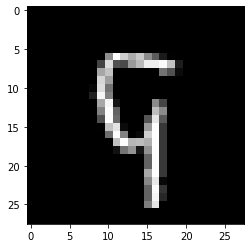

In [41]:
idx = 62
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

Sample instance from the MNIST data set.


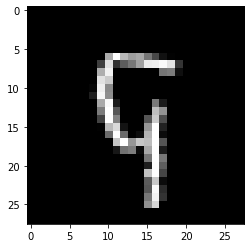

In [42]:
xa = X_test_adv[idx: idx + 1]
plt.imshow(np.squeeze(xa), 'gray')
print('Sample instance from the MNIST data set.')

In [43]:
model.predict(x)

array([[5.9266466e-05, 1.2331576e-07, 9.3980640e-07, 1.3373129e-05,
        4.4157263e-04, 3.0202422e-02, 3.3869042e-06, 4.4917726e-04,
        4.5184811e-04, 9.6837783e-01]], dtype=float32)

In [44]:
model.predict(xa)

array([[4.7330902e-04, 1.4470531e-06, 1.4027635e-06, 2.0992356e-05,
        7.8693719e-04, 7.8401476e-01, 1.4045305e-04, 3.1453423e-04,
        1.9764656e-03, 2.1226983e-01]], dtype=float32)

In [49]:
np.allclose(m.predict(X_test), model.predict(X_test))

True

In [50]:
np.allclose(m.predict(X_test_adv), model.predict(X_test_adv))

True

### nn detection on probability space

In [51]:
from keras import backend as K

In [52]:
inp = m.input
outs = {l.name: l.output for l in m.layers}
predict_fns = {name: K.function([inp], [out]) for name, out in outs.items()}
def predict_fn(x):
    layer = predict_fns['logits']([x])
    return layer[0]

In [53]:
predict_fn(X_test)

array([[ -4.239617  ,  -1.508783  ,  -0.05489746, ...,  17.590229  ,
         -6.341765  ,   1.1921233 ],
       [ -0.18943153,   7.580762  ,  20.29543   , ...,  -4.062213  ,
         -5.108464  , -13.609106  ],
       [ -5.1454625 ,  11.899247  ,  -4.155996  , ...,  -1.5164244 ,
         -4.4825125 ,  -6.0340548 ],
       ...,
       [ -7.148399  ,   1.7326717 ,  -3.6769767 , ...,  -4.9139953 ,
          0.9870071 ,   2.7176814 ],
       [ 11.486682  ,  -2.779151  ,   0.27755943, ...,   1.275965  ,
          1.5617647 ,  -0.600761  ],
       [ -1.257326  ,  -3.7156506 ,  -5.151019  , ..., -11.373561  ,
          1.9156134 ,  -4.0326858 ]], dtype=float32)

In [54]:
def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    print(sigma_plus)
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

def calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=100, nb_sigmas=3):
    
    X_train_samples = np.random.permutation(X_train)[:nb_samples]
    preds_train = predict_fn(X_train_samples)
    nn = NearestNeighbors()
    nn.fit(preds_train)
    
    preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
    dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
    dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

    df_dist = pd.DataFrame()
    df_dist['test'] = dist_test.flatten()
    df_dist['adv'] = dist_adv.flatten()
    
    perc, sigma_plus = _calculate_perc(df_dist, nb_sigmas=nb_sigmas)
    
    return perc, df_dist, sigma_plus

In [55]:
m.predict(x)

array([[5.9266466e-05, 1.2331576e-07, 9.3980640e-07, 1.3373128e-05,
        4.4157260e-04, 3.0202422e-02, 3.3869039e-06, 4.4917723e-04,
        4.5184809e-04, 9.6837783e-01]], dtype=float32)

In [56]:
nbs = []
percs = []
def predict_fn(x):
    return m.predict(x)
for nb_samples in [10, 50, 100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]:
    print(nb_samples)
    perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_test, X_test_adv, 
                                                  predict_fn, nb_samples=nb_samples, nb_sigmas=5)
    print(perc)
    nbs.append(nb_samples)
    percs.append(perc)
df_curve = pd.DataFrame()
df_curve['nb_samples'] = nbs
df_curve['percs'] = percs

10
3.397680342197418
0.0
50
0.3094337164844524
0.31999999999999995
100
0.27704505706393445
0.374
200
0.28144615515832483
0.31999999999999995
300
0.27317868523789646
0.31400000000000006
400
0.2244899148857105
0.45799999999999996
500
0.24223129057916337
0.33799999999999997
1000
0.2098578809378673
0.352
1500
0.15405188696328814
0.472
2000
0.18535638630990078
0.29200000000000004
2500
0.13217955931762962
0.374
3000
0.16601692152779127
0.352
3500
0.17899788966797975
0.238
4000
0.13548161092503375
0.33799999999999997
4500
0.1368785935523923
0.3540000000000001
5000
0.09047063531851982
0.366


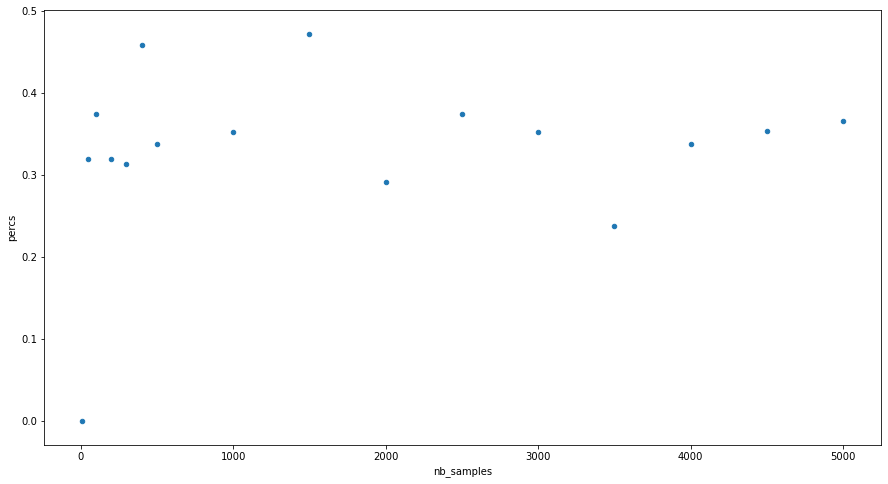

In [57]:
df_curve.plot(kind='scatter', x='nb_samples', y='percs', logx=False, figsize=(15, 8))

In [63]:
perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=1000, nb_sigmas=5)

0.16531605861214083


In [64]:
perc

0.404

In [65]:
df_dist.describe(percentiles=[0.5, 0.9, 1-perc])

,test,adv
count,5.000000e+02,5.000000e+02
mean,5.660448e-03,1.428259e-01
std,3.193112e-02,1.147732e-01
min,4.328917e-10,4.328917e-10
50%,4.484740e-06,1.295569e-01
59.6%,1.637910e-05,1.651172e-01
90%,1.753229e-03,2.973511e-01
max,3.469733e-01,5.542469e-01


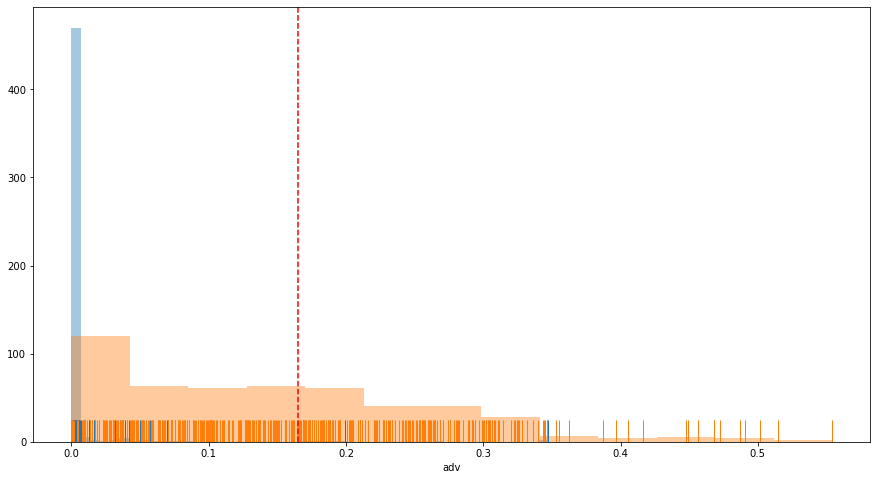

In [66]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_dist['test'], rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(df_dist['adv'], rug=True,ax=ax, kde=False)

In [67]:
dist_test, dist_adv = df_dist['test'].values, df_dist['adv'].values

In [68]:
x_bl =  np.concatenate((dist_test, dist_adv))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv))))

In [69]:
min_bl = dist_test.mean()
max_bl = dist_adv.mean() + 10 * dist_adv.std()

### define vae

In [70]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [71]:
vae = vsf.VaeSymmetryFinderConvKeras(m, input_shape=(28, 28, 1), rgb_filters=1, dropout=None,
                            output_shape=(10, ), nb_conv_layers=2, lr=0.001, strides=2,  
                            intermediate_dim=512, variational=True, opt='Adam',
                            latent_dim=1024, loss_type='kl_1', add_latent_loss=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 128)    73856       conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 6272)         0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
z_mean (De

## Detect through symmetry 

In [72]:
mcp = ModelCheckpoint('vae_weights_mnist_adv.h5', 
                      monitor='val_loss', 
                      verbose=1, 
                      save_best_only=True, 
                      save_weights_only=True, 
                      mode='auto', period=1)
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='auto')

In [73]:
vae.fit(X_train, x_test=X_test, epochs=150, callbacks=[mcp, es])

Train on 60000 samples, validate on 500 samples
Epoch 1/150
60000/60000 [==============================] - 12s 196us/step - loss: 0.4331 - val_loss: 0.0731

Epoch 00001: val_loss improved from inf to 0.07314, saving model to vae_weights_mnist_adv.h5
Epoch 2/150
60000/60000 [==============================] - 10s 163us/step - loss: 0.1100 - val_loss: 0.0625

Epoch 00002: val_loss improved from 0.07314 to 0.06250, saving model to vae_weights_mnist_adv.h5
Epoch 3/150
60000/60000 [==============================] - 10s 163us/step - loss: 0.0944 - val_loss: 0.0385

Epoch 00003: val_loss improved from 0.06250 to 0.03850, saving model to vae_weights_mnist_adv.h5
Epoch 4/150
60000/60000 [==============================] - 10s 163us/step - loss: 0.0856 - val_loss: 0.0324

Epoch 00004: val_loss improved from 0.03850 to 0.03244, saving model to vae_weights_mnist_adv.h5
Epoch 5/150
60000/60000 [==============================] - 10s 163us/step - loss: 0.0815 - val_loss: 0.0270

Epoch 00005: val_loss i

60000/60000 [==============================] - 10s 163us/step - loss: 0.0611 - val_loss: 0.0171

Epoch 00049: val_loss did not improve from 0.01542
Epoch 50/150
60000/60000 [==============================] - 10s 163us/step - loss: 0.0586 - val_loss: 0.0243

Epoch 00050: val_loss did not improve from 0.01542
Epoch 51/150
60000/60000 [==============================] - 10s 163us/step - loss: 0.0599 - val_loss: 0.0252

Epoch 00051: val_loss did not improve from 0.01542
Epoch 52/150
60000/60000 [==============================] - 10s 163us/step - loss: 0.0601 - val_loss: 0.0192

Epoch 00052: val_loss did not improve from 0.01542
Epoch 53/150
60000/60000 [==============================] - 10s 163us/step - loss: 0.0577 - val_loss: 0.0234

Epoch 00053: val_loss did not improve from 0.01542
Epoch 54/150
60000/60000 [==============================] - 10s 163us/step - loss: 0.0609 - val_loss: 0.0245

Epoch 00054: val_loss did not improve from 0.01542
Epoch 55/150
60000/60000 [=====================

In [74]:
vae.save(arch_path='vae_arch_mnist_adv.json', weights_path='vae_weights_mnist_adv_2.h5', save_model_only=True)

In [75]:
vae_loaded = vsf.load_vae(arch_path='vae_arch_mnist_adv.json', 
                          weights_path='vae_weights_mnist_adv.h5', 
                         model_type='keras', signal_type='kl_1')
#vae_loaded = vae

Loaded model from disk


## Stream

In [76]:
# Symmetry signal
#X_train_perm = np.random.permutation(X_train)
#X_test_perm = np.random.permutation(X_test)
#X_adv_perm = np.random.permutation(X_adv)

amp = 1
kl_train = vae_loaded.signal(X_train, amp=amp)
kl_test = vae_loaded.signal(X_test, amp=amp)
kl_adv = vae_loaded.signal(X_test_adv, amp=amp)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [77]:
vae_loaded.predict_original(x)

array([[5.9266466e-05, 1.2331576e-07, 9.3980640e-07, 1.3373128e-05,
        4.4157260e-04, 3.0202422e-02, 3.3869039e-06, 4.4917723e-04,
        4.5184809e-04, 9.6837783e-01]], dtype=float32)

In [78]:
vae_loaded.transform_predict(x)

array([[6.9588440e-04, 6.5719429e-04, 2.8782123e-04, 6.4832112e-03,
        1.2274800e-02, 2.7306211e-01, 1.8345453e-04, 2.0224319e-03,
        6.2548118e-03, 6.9807822e-01]], dtype=float32)

In [79]:
vae_loaded.predict_original(xa)

array([[4.7330896e-04, 1.4470530e-06, 1.4027634e-06, 2.0992355e-05,
        7.8693713e-04, 7.8401464e-01, 1.4045303e-04, 3.1453421e-04,
        1.9764653e-03, 2.1226981e-01]], dtype=float32)

In [80]:
vae_loaded.transform_predict(xa)

array([[6.6938478e-04, 1.2799536e-03, 2.6107987e-04, 6.9390726e-03,
        1.0766250e-02, 7.2127670e-01, 5.2001892e-04, 1.1484683e-03,
        8.4588155e-03, 2.4868020e-01]], dtype=float32)

In [81]:
print(kl_train.mean(), kl_train.std())

0.014832254 0.08678058


In [82]:
print(kl_test.mean(), kl_test.std())

0.014793792 0.07050221


In [83]:
print(kl_adv.mean(), kl_adv.std())

1.5762141 1.6102718


### Detector curves

In [84]:
x_kl = np.concatenate((kl_test, kl_adv))
y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv))))

In [85]:
min_train = kl_train.mean()
max_train = kl_train.mean() + 10 * kl_train.std()

In [86]:
trs = np.arange(min_train, max_train, 0.001)

In [87]:
#X_train_samples = np.random.permutation(X_train)[:100]
#preds_train = predict_fn(X_train_samples)
#nn = NearestNeighbors()
#nn.fit(preds_train)
    
#preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
#dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
#dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

In [88]:
#x_bl =  np.concatenate((dist_test, dist_adv))
#y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv))))

In [89]:
min_bl = dist_test.mean()
max_bl = dist_adv.mean() + 10 * dist_adv.std()

In [90]:
max_train

0.8826380325481296

In [91]:
max_bl

1.289409420807023

In [92]:
trs = np.arange(0, max_bl, 0.001)

In [93]:
def predict_adv(x, tr):
    return (x >= tr).astype(int)

In [94]:
tresholds, precs, recals, accs = [], [], [], []
precs_bl, recals_bl, accs_bl = [], [], []
for tr in trs:
    preds_kl = predict_adv(x_kl, tr)
    preds_bl = predict_adv(x_bl, tr)
    
    prec = precision_score(y_kl, preds_kl)
    rec = recall_score(y_kl, preds_kl)
    acc= accuracy_score(y_kl, preds_kl)

    prec_bl = precision_score(y_bl, preds_bl)
    rec_bl = recall_score(y_bl, preds_bl)
    acc_bl = accuracy_score(y_bl, preds_bl)
    
    tresholds.append(tr)
    precs.append(prec)
    recals.append(rec)
    accs.append(acc)
    
    precs_bl.append(prec_bl)
    recals_bl.append(rec_bl)
    accs_bl.append(acc_bl)


df_scores = pd.DataFrame()
df_scores['trs'] = tresholds
df_scores['precs'] = precs
df_scores['recs'] = recals
df_scores['accs'] = accs

df_scores['precs_bl'] = precs_bl
df_scores['recs_bl'] = recals_bl
df_scores['accs_bl'] = accs_bl

/home/Gigio/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


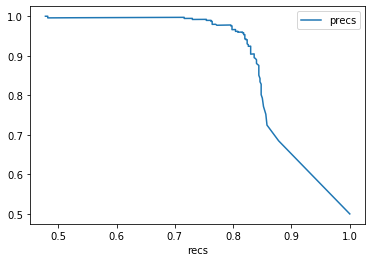

In [95]:
df_scores.plot(x='recs', y='precs')

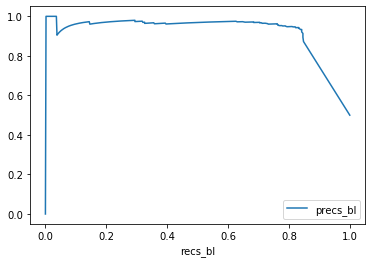

In [96]:
df_scores.plot(x='recs_bl', y='precs_bl')

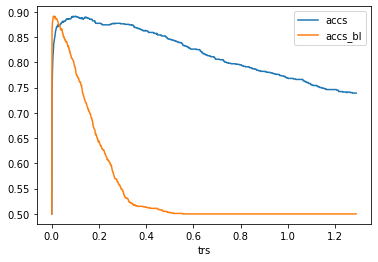

In [97]:
df_scores.plot(x= 'trs',y=['accs', 'accs_bl'])

In [98]:
df_scores.describe()

,trs,precs,recs,accs,precs_bl,recs_bl,accs_bl
count,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000
mean,0.644500,0.986304,0.647913,0.817963,0.419543,0.111144,0.553033
std,0.372535,0.030348,0.111336,0.050498,0.483406,0.221744,0.105355
min,0.000000,0.500000,0.478000,0.500000,0.000000,0.000000,0.500000
25%,0.322250,0.989610,0.550000,0.774000,0.000000,0.000000,0.500000
50%,0.644500,0.996269,0.636000,0.815500,0.000000,0.000000,0.500000
75%,0.966750,0.996711,0.758000,0.871000,0.971072,0.063500,0.528750
max,1.289000,1.000000,1.000000,0.891000,1.000000,1.000000,0.891000


### Signal histograms

In [99]:
df_kl = pd.DataFrame()
df_kl['test'] = kl_test
df_kl['adv'] = kl_adv

In [100]:
def _calculate(df_tmp, nb_sigmas=3):
    print(nb_sigmas)
    sp = df_tmp['test'].mean() + (nb_sigmas * df_tmp['adv'].std())
    ps = percentileofscore(df_tmp['adv'], sp) * 0.01
    p = 1 - ps
    return p, sp


In [101]:
_calculate(df_kl)

3


(0.040000000000000036, 4.850447928532958)

In [102]:
def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    print(sigma_plus)
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

In [103]:
_calculate_perc(df_kl, nb_sigmas=5)

0.36765783093869686


(0.74, 0.36765783093869686)

In [104]:
nb_sigmas = 3
sigma_plus = df_kl['test'].mean() + (nb_sigmas * df_kl['test'].std())
sigma_plus

0.2265122141689062

In [105]:
pc_sigma = percentileofscore(df_kl['adv'], sigma_plus) * 0.01
print('Percentage within {} sigmas: {}'.format(nb_sigmas, pc_sigma))
print('Percentage beyond {} sigmas: {}'.format(nb_sigmas, ( 1 - pc_sigma)))

Percentage within 3 sigmas: 0.23600000000000002
Percentage beyond 3 sigmas: 0.764


In [106]:
df_kl.describe(percentiles=[0.5, 0.9, pc_sigma])

,test,adv
count,5.000000e+02,5.000000e+02
mean,1.479379e-02,1.576213e+00
std,7.057281e-02,1.611885e+00
min,3.046163e-07,6.450098e-07
23.6%,6.071742e-05,2.528592e-01
50%,5.083100e-04,1.146428e+00
90%,1.965352e-02,3.546764e+00
max,1.251270e+00,1.167958e+01


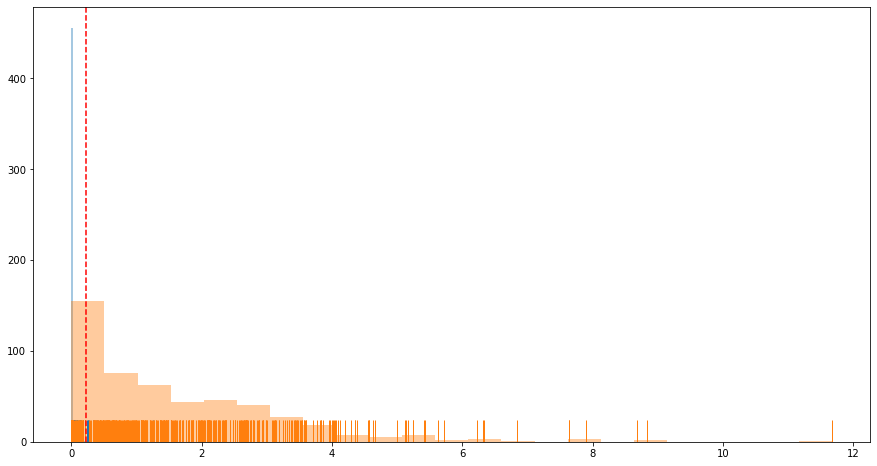

In [107]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(kl_adv, rug=True,ax=ax, kde=False)

### Sudden drift

In [108]:
df = sst.make_data_stream(kl_concat, agg='mean')

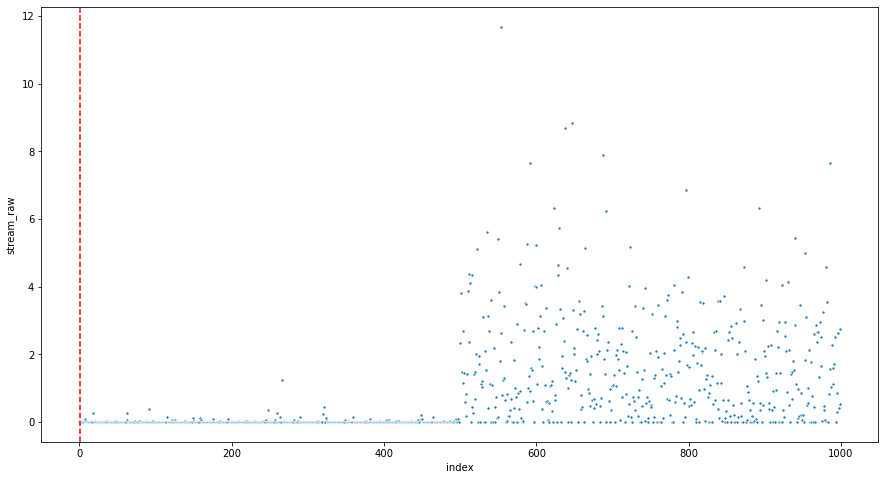

In [109]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="stream_raw", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(tr, c='r', linestyle='dashed')

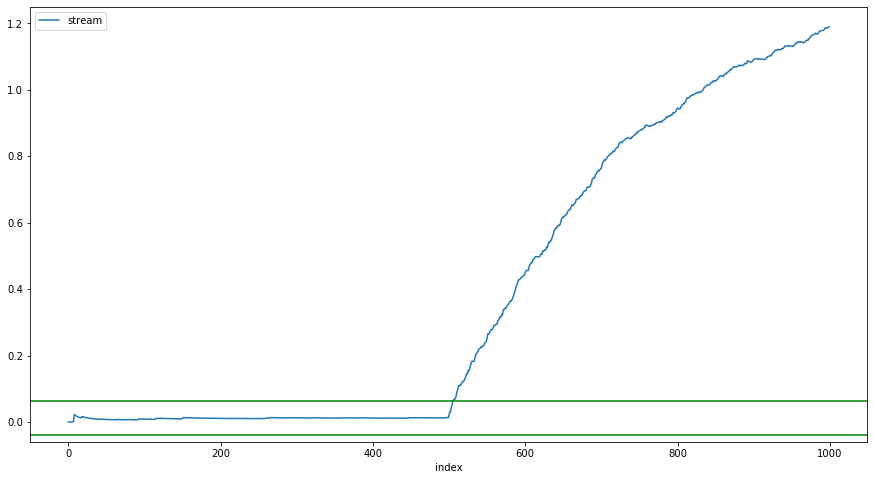

In [124]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus / amp, c='g')
ax.axhline(baseline_std_minus / amp, c='g')

In [125]:
adwin = ADWIN(delta=0.002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < tr:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.34367286470222447 - at index: 575
Change detected in data: 0.47625243214830276 - at index: 607
Change detected in data: 0.5777940379005838 - at index: 639
Change detected in data: 0.675044799601844 - at index: 671
Change detected in data: 0.7841896882086875 - at index: 703
Change detected in data: 0.8553580386847699 - at index: 735
Change detected in data: 0.8930514450962304 - at index: 767
Change detected in data: 0.9428532639082102 - at index: 799
Change detected in data: 0.9944887160576242 - at index: 831
Change detected in data: 1.083823597489608 - at index: 895
Change detected in data: 1.1139194365663299 - at index: 927
Change detected in data: 1.178463333783177 - at index: 991


### Gradual drift

In [126]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae_loaded, X_test, y_test, X_test_adv, y_test_adv, cd_start, cd_full, nb_samples_tot, start, amp=amp)

Sample 0 of 6000
Sample 1000 of 6000
Sample 2000 of 6000
Sample 3000 of 6000
Sample 4000 of 6000
Sample 5000 of 6000


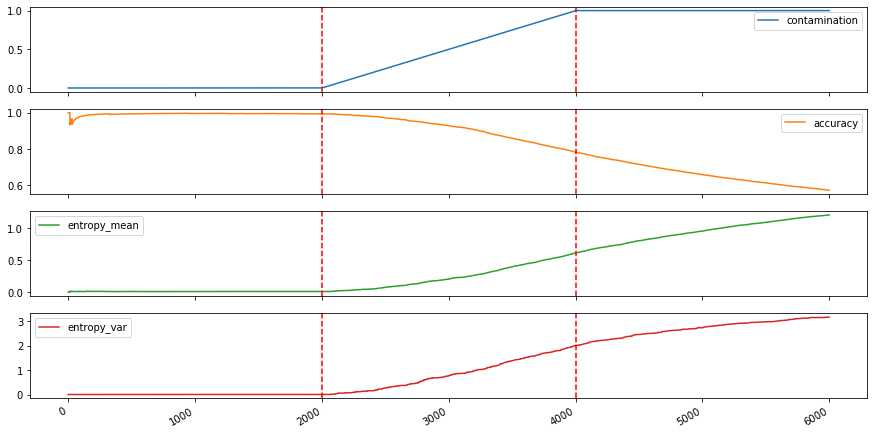

In [127]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

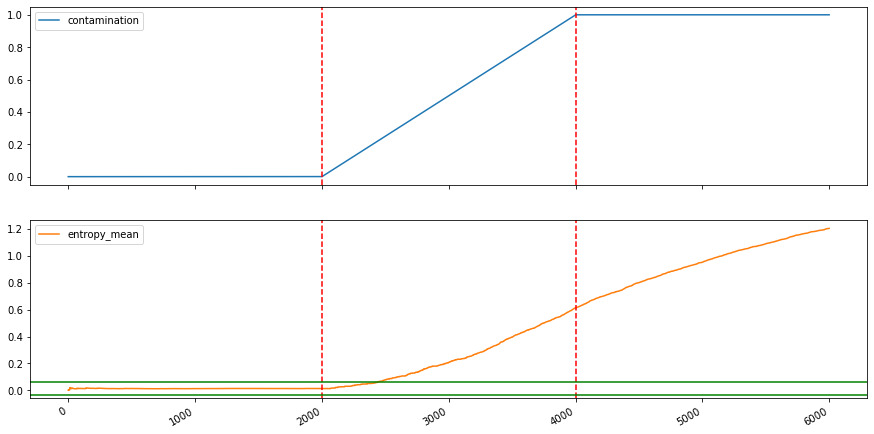

In [128]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus / amp, c='g')
axs[1].axhline(baseline_std_minus / amp, c='g')


In [129]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.002)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.07711264671149078 - at index: 2495
Change detected in data: 0.08355269563864437 - at index: 2527
Change detected in data: 0.09158019371951413 - at index: 2559
Change detected in data: 0.10005820540395843 - at index: 2591
Change detected in data: 0.10735163989654284 - at index: 2655
Change detected in data: 0.12150794627688193 - at index: 2687
Change detected in data: 0.13355530740835744 - at index: 2751
Change detected in data: 0.16081551938385952 - at index: 2815
Change detected in data: 0.19070396378955567 - at index: 2943
Change detected in data: 0.23129350492440168 - at index: 3071
Change detected in data: 0.264515290256362 - at index: 3199
Change detected in data: 0.3148684856838106 - at index: 3327
Change detected in data: 0.3802975255164213 - at index: 3455
Change detected in data: 0.41878628868650614 - at index: 3551
Change detected in data: 0.4320072350287201 - at index: 3583
Change detected in data: 0.45635541152006 - at index: 3647
Change detected 

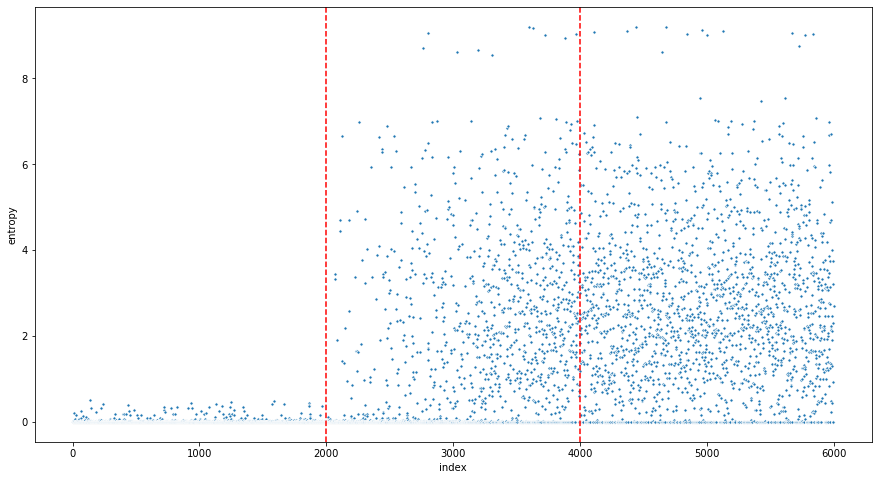

In [130]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="entropy", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(cd_start, c='r', linestyle='dashed')
plt.axvline(cd_full, c='r', linestyle='dashed')

# Cifar

In [3]:
NB_EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
CLEAN_TRAIN = True
BACKPROP_THROUGH_ATTACK = False
NB_FILTERS = 64

In [4]:
train_start=0
train_end=60000
test_start=0                 
test_end=10000
nb_epochs=NB_EPOCHS
batch_size=BATCH_SIZE
learning_rate=LEARNING_RATE
clean_train=CLEAN_TRAIN
testing=False
backprop_through_attack=BACKPROP_THROUGH_ATTACK
nb_filters=NB_FILTERS
num_threads=None
label_smoothing=0.1

In [5]:
report = AccuracyReport()

  # Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

  # Set logging level to see debug information
set_log_level(logging.DEBUG)

  # Create TF session
if num_threads:
    config_args = dict(intra_op_parallelism_threads=1)
else:
    config_args = {}
sess = tf.Session(config=tf.ConfigProto(**config_args))

  # Get CIFAR10 data
data = CIFAR10(train_start=train_start, train_end=train_end,
                 test_start=test_start, test_end=test_end)
dataset_size = data.x_train.shape[0]
dataset_train = data.to_tensorflow()[0]
dataset_train = dataset_train.map(
      lambda x, y: (random_shift(random_horizontal_flip(x)), y), 4)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(16)
X_train, y_train = data.get_set('train')
X_test, y_test = data.get_set('test')

  # Use Image Parameters
img_rows, img_cols, nchannels = X_test.shape[1:4]
nb_classes = y_test.shape[1]

  # Define input TF placeholder
x_pl = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols,
                                        nchannels))
y_pl = tf.placeholder(tf.float32, shape=(None, nb_classes))

  # Train an MNIST model
train_params = {
      'nb_epochs': nb_epochs,
      'batch_size': batch_size,
      'learning_rate': learning_rate
  }
eval_params = {'batch_size': batch_size}
fgsm_params = {
      'eps': 0.3,
      'clip_min': 0.,
      'clip_max': 1.
  }
rng = np.random.RandomState([2017, 8, 30])

def do_eval(preds, x_set, y_set, report_key, is_adv=None):
    acc = model_eval(sess, x_pl, y_pl, preds, x_set, y_set, args=eval_params)
    setattr(report, report_key, acc)
    if is_adv is None:
        report_text = None
    elif is_adv:
        report_text = 'adversarial'
    else:
        report_text = 'legitimate'
    if report_text:
        print('Test accuracy on %s examples: %0.4f' % (report_text, acc))

if clean_train:
    model = ModelAllConvolutional('model1', nb_classes, nb_filters,
                                  input_shape=[32, 32, 3])
    preds = model.get_logits(x_pl)
    loss = CrossEntropy(model, smoothing=label_smoothing)

def evaluate():
    do_eval(preds, X_test, y_test, 'clean_train_clean_eval', False)

train(sess, loss, None, None,
          dataset_train=dataset_train, dataset_size=dataset_size,
          evaluate=evaluate, args=train_params, rng=rng,
          var_list=model.get_params())

    # Calculate training error
if testing:
    do_eval(preds, X_train, y_train, 'train_clean_train_clean_eval')

    # Initialize the Fast Gradient Sign Method (FGSM) attack object and
    # graph
fgsm = FastGradientMethod(model, sess=sess)
adv_x = fgsm.generate(x_pl, **fgsm_params)
preds_adv = model.get_logits(adv_x)

    # Evaluate the accuracy of the MNIST model on adversarial examples
do_eval(preds_adv, X_test, y_test, 'clean_train_adv_eval', True)

    # Calculate training error
if testing:
    do_eval(preds_adv, X_train, y_train, 'train_clean_train_adv_eval')

print('Repeating the process, using adversarial training')

  # Create a new model and train it to be robust to FastGradientMethod
model2 = ModelAllConvolutional('model2', nb_classes, nb_filters,
                                 input_shape=[32, 32, 3])
fgsm2 = FastGradientMethod(model2, sess=sess)

def attack(x):
    return fgsm2.generate(x, **fgsm_params)

loss2 = CrossEntropy(model2, smoothing=label_smoothing, attack=attack)
preds2 = model2.get_logits(x_pl)
adv_x2 = attack(x_pl)

if not backprop_through_attack:
    # For the fgsm attack used in this tutorial, the attack has zero
    # gradient so enabling this flag does not change the gradient.
    # For some other attacks, enabling this flag increases the cost of
    # training, but gives the defender the ability to anticipate how
    # the atacker will change their strategy in response to updates to
    # the defender's parameters.
    adv_x2 = tf.stop_gradient(adv_x2)
preds2_adv = model2.get_logits(adv_x2)

def evaluate2():
    # Accuracy of adversarially trained model on legitimate test inputs
    do_eval(preds2, X_test, y_test, 'adv_train_clean_eval', False)
    # Accuracy of the adversarially trained model on adversarial examples
    do_eval(preds2_adv, X_test, y_test, 'adv_train_adv_eval', True)

  # Perform and evaluate adversarial training
train(sess, loss2, None, None,
        dataset_train=dataset_train, dataset_size=dataset_size,
        evaluate=evaluate2, args=train_params, rng=rng,
        var_list=model2.get_params())

  # Calculate training errors
if testing:
    do_eval(preds2, X_train, y_train, 'train_adv_train_clean_eval')
    do_eval(preds2_adv, X_train, y_train, 'train_adv_train_adv_eval')
print('Done')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
num_devices:  1


[INFO 2019-10-28 15:07:10,241 cleverhans] Epoch 0 took 12.679786205291748 seconds


Test accuracy on legitimate examples: 0.4872


[INFO 2019-10-28 15:07:22,552 cleverhans] Epoch 1 took 11.483542680740356 seconds


Test accuracy on legitimate examples: 0.6485


[INFO 2019-10-28 15:07:34,836 cleverhans] Epoch 2 took 11.510642051696777 seconds


Test accuracy on legitimate examples: 0.6967


[INFO 2019-10-28 15:07:47,157 cleverhans] Epoch 3 took 11.542885065078735 seconds


Test accuracy on legitimate examples: 0.7551


[INFO 2019-10-28 15:07:59,436 cleverhans] Epoch 4 took 11.509101867675781 seconds


Test accuracy on legitimate examples: 0.7872


[INFO 2019-10-28 15:08:11,738 cleverhans] Epoch 5 took 11.523093223571777 seconds


Test accuracy on legitimate examples: 0.7849


[INFO 2019-10-28 15:08:24,031 cleverhans] Epoch 6 took 11.521440982818604 seconds


Test accuracy on legitimate examples: 0.8188


[INFO 2019-10-28 15:08:36,325 cleverhans] Epoch 7 took 11.515643119812012 seconds


Test accuracy on legitimate examples: 0.8269


[INFO 2019-10-28 15:08:48,621 cleverhans] Epoch 8 took 11.517538785934448 seconds


Test accuracy on legitimate examples: 0.8330


[INFO 2019-10-28 15:09:00,910 cleverhans] Epoch 9 took 11.514426946640015 seconds


Test accuracy on legitimate examples: 0.8372


[INFO 2019-10-28 15:09:13,230 cleverhans] Epoch 10 took 11.54538631439209 seconds


Test accuracy on legitimate examples: 0.8457


[INFO 2019-10-28 15:09:25,519 cleverhans] Epoch 11 took 11.514847993850708 seconds


Test accuracy on legitimate examples: 0.8535


[INFO 2019-10-28 15:09:37,809 cleverhans] Epoch 12 took 11.514491081237793 seconds


Test accuracy on legitimate examples: 0.8566


[INFO 2019-10-28 15:09:50,194 cleverhans] Epoch 13 took 11.605460166931152 seconds


Test accuracy on legitimate examples: 0.8644


[INFO 2019-10-28 15:10:02,544 cleverhans] Epoch 14 took 11.566495656967163 seconds


Test accuracy on legitimate examples: 0.8652


[INFO 2019-10-28 15:10:14,863 cleverhans] Epoch 15 took 11.54585313796997 seconds


Test accuracy on legitimate examples: 0.8647


[INFO 2019-10-28 15:10:27,154 cleverhans] Epoch 16 took 11.517215728759766 seconds


Test accuracy on legitimate examples: 0.8776


[INFO 2019-10-28 15:10:39,476 cleverhans] Epoch 17 took 11.54130744934082 seconds


Test accuracy on legitimate examples: 0.8673


[INFO 2019-10-28 15:10:51,794 cleverhans] Epoch 18 took 11.537827014923096 seconds


Test accuracy on legitimate examples: 0.8745


[INFO 2019-10-28 15:11:04,115 cleverhans] Epoch 19 took 11.551781415939331 seconds


Test accuracy on legitimate examples: 0.8773


/home/Gigio/git/fork-cleverhans/cleverhans/attacks_tf.py:27: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locations directly.
  warnings.warn("attacks_tf is deprecated and will be removed on 2019-07-18"
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max at 0x7f43154f52f0> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f43154eea60> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but supp

Test accuracy on adversarial examples: 0.1027
Repeating the process, using adversarial training


/home/Gigio/git/fork-cleverhans/cleverhans/loss.py:41: UserWarning: callable attacks are deprecated, switch to an Attack subclass. callable attacks will not be supported after 2019-05-05.
  warnings.warn("callable attacks are deprecated, switch to an Attack "


num_devices:  1


[INFO 2019-10-28 15:11:38,225 cleverhans] Epoch 0 took 27.71207332611084 seconds


Test accuracy on legitimate examples: 0.3618
Test accuracy on adversarial examples: 0.1714


[INFO 2019-10-28 15:12:09,264 cleverhans] Epoch 1 took 27.38006353378296 seconds


Test accuracy on legitimate examples: 0.5990
Test accuracy on adversarial examples: 0.4311


[INFO 2019-10-28 15:12:39,965 cleverhans] Epoch 2 took 27.481393098831177 seconds


Test accuracy on legitimate examples: 0.6708
Test accuracy on adversarial examples: 0.5467


[INFO 2019-10-28 15:13:10,612 cleverhans] Epoch 3 took 27.433262586593628 seconds


Test accuracy on legitimate examples: 0.7265
Test accuracy on adversarial examples: 0.5975


[INFO 2019-10-28 15:13:41,310 cleverhans] Epoch 4 took 27.475255012512207 seconds


Test accuracy on legitimate examples: 0.7259
Test accuracy on adversarial examples: 0.6364


[INFO 2019-10-28 15:14:12,028 cleverhans] Epoch 5 took 27.489441871643066 seconds


Test accuracy on legitimate examples: 0.7585
Test accuracy on adversarial examples: 0.6887


[INFO 2019-10-28 15:14:42,711 cleverhans] Epoch 6 took 27.46079397201538 seconds


Test accuracy on legitimate examples: 0.7919
Test accuracy on adversarial examples: 0.7023


[INFO 2019-10-28 15:15:13,445 cleverhans] Epoch 7 took 27.510754346847534 seconds


Test accuracy on legitimate examples: 0.8037
Test accuracy on adversarial examples: 0.7250


[INFO 2019-10-28 15:15:44,140 cleverhans] Epoch 8 took 27.462427377700806 seconds


Test accuracy on legitimate examples: 0.8173
Test accuracy on adversarial examples: 0.7428


[INFO 2019-10-28 15:16:14,819 cleverhans] Epoch 9 took 27.458906650543213 seconds


Test accuracy on legitimate examples: 0.8068
Test accuracy on adversarial examples: 0.7573


[INFO 2019-10-28 15:16:45,517 cleverhans] Epoch 10 took 27.478805780410767 seconds


Test accuracy on legitimate examples: 0.8158
Test accuracy on adversarial examples: 0.7593


[INFO 2019-10-28 15:17:16,189 cleverhans] Epoch 11 took 27.4525408744812 seconds


Test accuracy on legitimate examples: 0.8309
Test accuracy on adversarial examples: 0.7570


[INFO 2019-10-28 15:17:46,887 cleverhans] Epoch 12 took 27.47890830039978 seconds


Test accuracy on legitimate examples: 0.8311
Test accuracy on adversarial examples: 0.7849


[INFO 2019-10-28 15:18:17,605 cleverhans] Epoch 13 took 27.486246824264526 seconds


Test accuracy on legitimate examples: 0.8466
Test accuracy on adversarial examples: 0.8163


[INFO 2019-10-28 15:18:48,288 cleverhans] Epoch 14 took 27.45728588104248 seconds


Test accuracy on legitimate examples: 0.8439
Test accuracy on adversarial examples: 0.8087


[INFO 2019-10-28 15:19:18,987 cleverhans] Epoch 15 took 27.480610132217407 seconds


Test accuracy on legitimate examples: 0.8408
Test accuracy on adversarial examples: 0.7912


[INFO 2019-10-28 15:19:49,710 cleverhans] Epoch 16 took 27.484564542770386 seconds


Test accuracy on legitimate examples: 0.8472
Test accuracy on adversarial examples: 0.8192


[INFO 2019-10-28 15:20:20,515 cleverhans] Epoch 17 took 27.56053590774536 seconds


Test accuracy on legitimate examples: 0.8532
Test accuracy on adversarial examples: 0.8185


[INFO 2019-10-28 15:20:51,207 cleverhans] Epoch 18 took 27.461504459381104 seconds


Test accuracy on legitimate examples: 0.8657
Test accuracy on adversarial examples: 0.8359


[INFO 2019-10-28 15:21:21,912 cleverhans] Epoch 19 took 27.46008038520813 seconds


Test accuracy on legitimate examples: 0.8505
Test accuracy on adversarial examples: 0.8150
Done


In [9]:
X_adv = sess.run(fgsm.generate(x_pl, sess=sess), feed_dict={x_pl: X_test[:1000]})
y_adv = y_test

/home/Gigio/git/fork-cleverhans/cleverhans/attacks/fast_gradient_method.py:122: UserWarning: kwargs is unused and will be removed on or after 2019-04-26.
  warnings.warn("kwargs is unused and will be removed on or after "
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max at 0x7f43154f52f0> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f43154eea60> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(s

Sample instance from the MNIST data set.


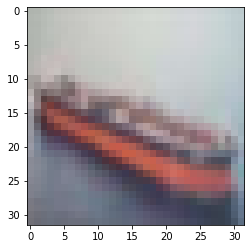

In [10]:
idx = 999
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample instance from the MNIST data set.


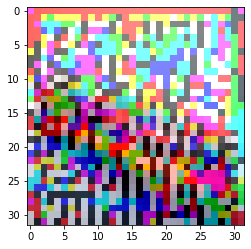

In [11]:
xa = X_adv[idx: idx + 1]
plt.imshow(np.squeeze(xa), 'gray')
print('Sample instance from the MNIST data set.')

In [34]:
sess.run(model.get_probs(x_pl), feed_dict={x_pl: x})

array([[0.02680327, 0.00680656, 0.00422867, 0.00439995, 0.00276608,
        0.00228287, 0.00274207, 0.00228873, 0.94373333, 0.00394845]],
      dtype=float32)

In [35]:
sess.run(model.get_probs(x_pl), feed_dict={x_pl: xa})

array([[0.03669943, 0.3080798 , 0.01204626, 0.01754826, 0.0241965 ,
        0.02278983, 0.04068958, 0.08311906, 0.05236148, 0.4024698 ]],
      dtype=float32)

## Train vae

In [301]:
vae = vsf.VaeSymmetryFinderConv(model, input_shape=(28, 28, 1), rgb_filters=1,
                            output_shape=(10, ), 
                            intermediate_dim=256, 
                            latent_dim=8, loss_type='symm')

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 14, 14, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 14, 14, 64)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 7, 7, 128)    73856       dropout_28[0][0]                 
__________________________________________________________________________________________________
dropou

In [302]:
vae.fit(X_train, x_test=X_test, epochs=50)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.6234 - val_loss: 0.1506
Epoch 2/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.1363 - val_loss: 0.0974
Epoch 3/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0929 - val_loss: 0.0772
Epoch 4/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0726 - val_loss: 0.0677
Epoch 5/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0617 - val_loss: 0.0590
Epoch 6/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0552 - val_loss: 0.0583
Epoch 7/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0497 - val_loss: 0.0561
Epoch 8/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0464 - val_loss: 0.0568
Epoch 9/50
60000/60000 [==============================] - 9s 143us/step - loss: 0.0442 - val_loss: 0.

In [303]:
vae.save(arch_path='vae_arch_mnist_adv.json', weights_path='vae_weights_mnist_adv.h5')

In [304]:
vae_loaded = vsf.load_vae(arch_path='vae_arch_mnist_adv.json', weights_path='vae_weights_mnist_adv.h5')

Loaded model from disk


## Stream

In [305]:
# Symmetry signal
X_train_perm = np.random.permutation(X_train)
X_test_perm = np.random.permutation(X_test)
X_adv_perm = np.random.permutation(X_adv)

amp = 0.5
kl_train = vae_loaded.signal(X_train_perm, amp=amp)
kl_test = vae_loaded.signal(X_test_perm, amp=amp)
kl_adv = vae_loaded.signal(X_adv_perm, amp=amp)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [306]:
vae.predict_original(x)

array([[0.00944898, 0.00931012, 0.01011397, 0.9144536 , 0.010226  ,
        0.00875417, 0.00966593, 0.00902877, 0.00955911, 0.0094393 ]],
      dtype=float32)

In [307]:
vae.transform_predict(x)

array([[0.00939064, 0.00621081, 0.01904817, 0.8708233 , 0.00673245,
        0.03239373, 0.01086471, 0.01453625, 0.01853919, 0.0114607 ]],
      dtype=float32)

In [308]:
vae.predict_original(xa)

array([[0.06550434, 0.05473979, 0.15493904, 0.12586369, 0.09562235,
        0.15378147, 0.07624201, 0.09200393, 0.08536093, 0.09594247]],
      dtype=float32)

In [309]:
vae.transform_predict(xa)

array([[0.00948455, 0.00613334, 0.01946554, 0.8695392 , 0.00683212,
        0.03270752, 0.01098244, 0.01475581, 0.01867487, 0.0114246 ]],
      dtype=float32)

In [310]:
kl_test.mean() + 2 * kl_test.std()

0.24636141769587994

In [317]:
df_kl = pd.DataFrame()
df_kl['test'] = - kl_test
df_kl['adv'] = - kl_adv

In [322]:
nb_sigmas = 3
sigma_plus = -(kl_test.mean() + nb_sigmas * kl_test.std())

In [323]:
pc_sigma = percentileofscore(df_kl['adv'], sigma_plus) * 0.01

In [324]:
sigma_plus

-0.3577089589089155

In [325]:
pc_sigma

0.9056000000000001

In [326]:
df_kl.describe(percentiles=[0.5, 0.9, pc_sigma])

,test,adv
count,10000.000000,10000.000000
mean,-0.023666,-0.709786
std,0.111353,0.225571
min,-1.897678,-1.371375
50%,-0.000577,-0.774687
90%,-0.000119,-0.368525
90.6%,-0.000114,-0.357703
max,-0.000007,-0.019792


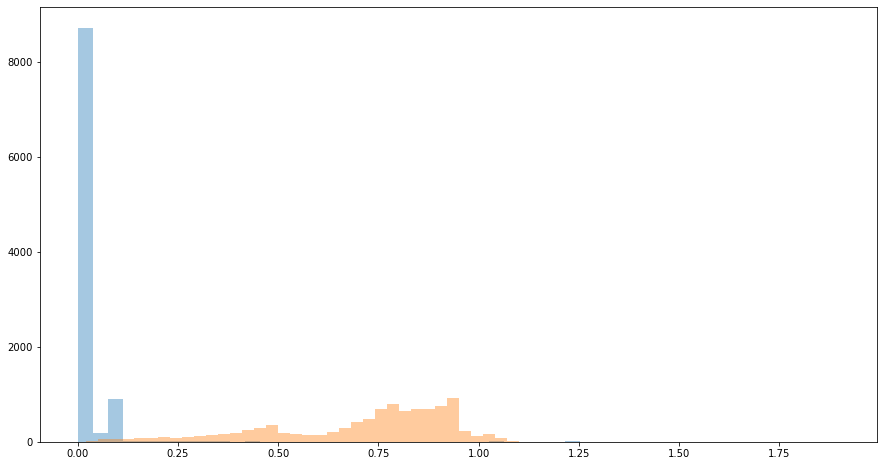

In [327]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, ax=ax, kde=False)
sns.distplot(kl_adv, ax=ax, kde=False)

### Sudden drift

In [328]:
df = sst.make_data_stream(kl_concat, agg='mean')

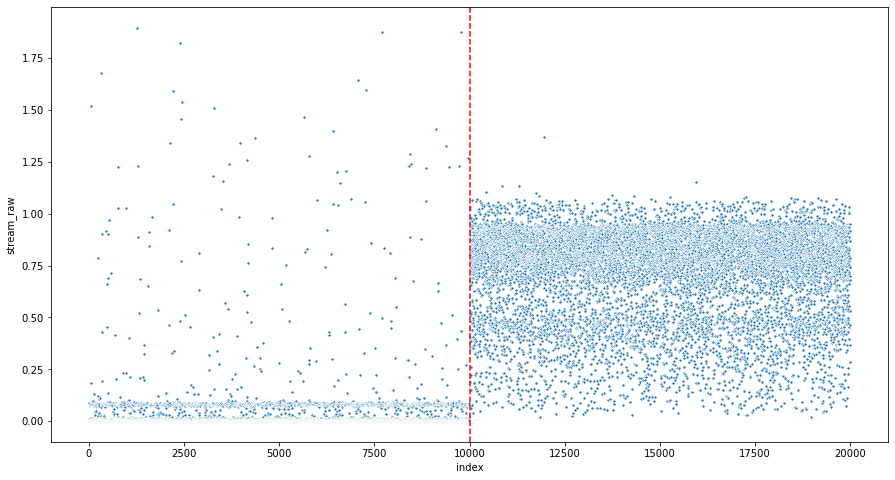

In [329]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="stream_raw", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(tr, c='r', linestyle='dashed')

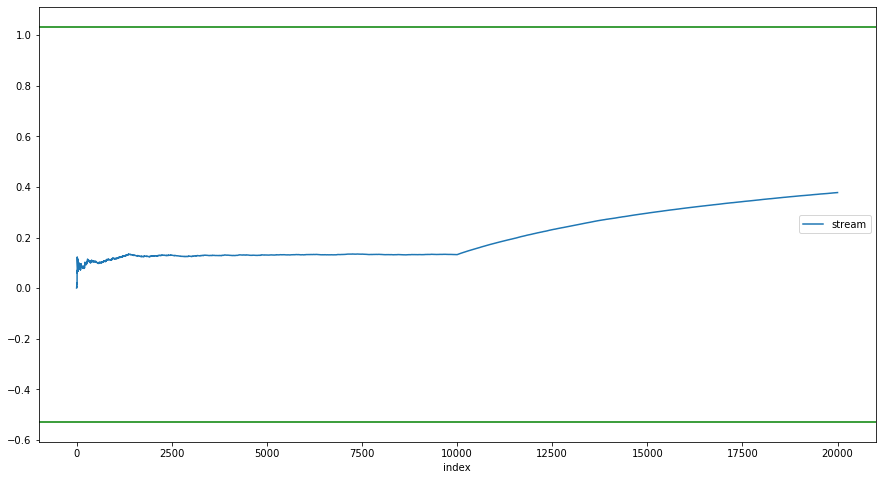

In [275]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus / amp, c='g')
ax.axhline(baseline_std_minus / amp, c='g')

In [276]:
adwin = ADWIN(delta=0.002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < tr:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.12986713712040188 - at index: 1535
Change detected in data: 0.13001620659477486 - at index: 2303
Change detected in data: 0.1296612836097956 - at index: 3583
Change detected in data: 0.1431412076843279 - at index: 10207
Change detected in data: 0.15905178767742434 - at index: 10559
Change detected in data: 0.16482531044181042 - at index: 10687
Change detected in data: 0.17024729698717844 - at index: 10815
Change detected in data: 0.17419336049850812 - at index: 10911
Change detected in data: 0.17931640717167727 - at index: 11039
Change detected in data: 0.18047034415918956 - at index: 11071
Change detected in data: 0.1875491626066638 - at index: 11263
Change detected in data: 0.1947314369929331 - at index: 11455
Change detected in data: 0.2007770629511228 - at index: 11615
Change detected in data: 0.2133539487484565 - at index: 11967
Change detected in data: 0.22404959297989246 - at index: 12287
Change detected in data: 0.23240619665297288 - at index: 12543
C

### Gradual drift

In [277]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae_loaded, X_test, y_test, X_adv, y_adv, cd_start, cd_full, nb_samples_tot, start, amp=amp)

Sample 0 of 6000
Sample 1000 of 6000
Sample 2000 of 6000
Sample 3000 of 6000
Sample 4000 of 6000
Sample 5000 of 6000


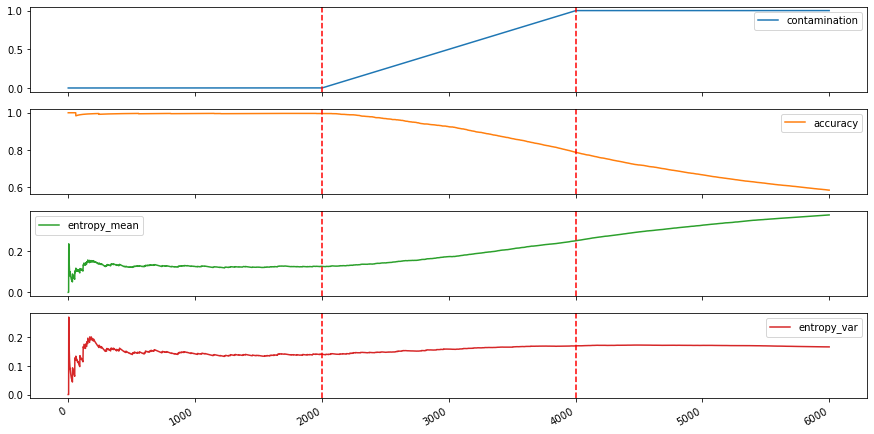

In [278]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

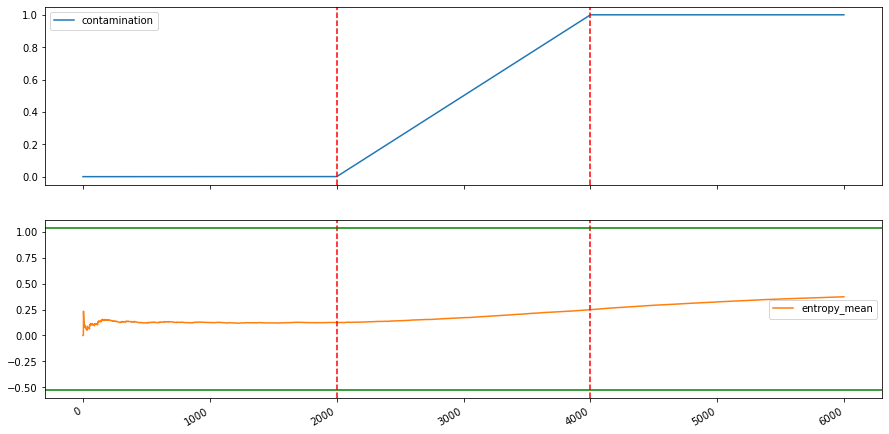

In [279]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus / amp, c='g')
axs[1].axhline(baseline_std_minus / amp, c='g')


In [280]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.002)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.16909600499207073 - at index: 2943
Change detected in data: 0.1730277312745748 - at index: 3007
Change detected in data: 0.18059271946378574 - at index: 3135
Change detected in data: 0.19501112986853206 - at index: 3327
Change detected in data: 0.21681595684198937 - at index: 3583
Change detected in data: 0.23332776763244614 - at index: 3807
Change detected in data: 0.23509566379057142 - at index: 3839
Change detected in data: 0.24636344471094118 - at index: 3967
Change detected in data: 0.2584067885163753 - at index: 4095
Change detected in data: 0.2697502076458331 - at index: 4223
Change detected in data: 0.2795744648028703 - at index: 4351
Change detected in data: 0.2901428441167881 - at index: 4479
Change detected in data: 0.2986059893543592 - at index: 4607
Change detected in data: 0.3068827446880567 - at index: 4735
Change detected in data: 0.31737838075892577 - at index: 4895
Change detected in data: 0.327523366162041 - at index: 5055
Change detected i

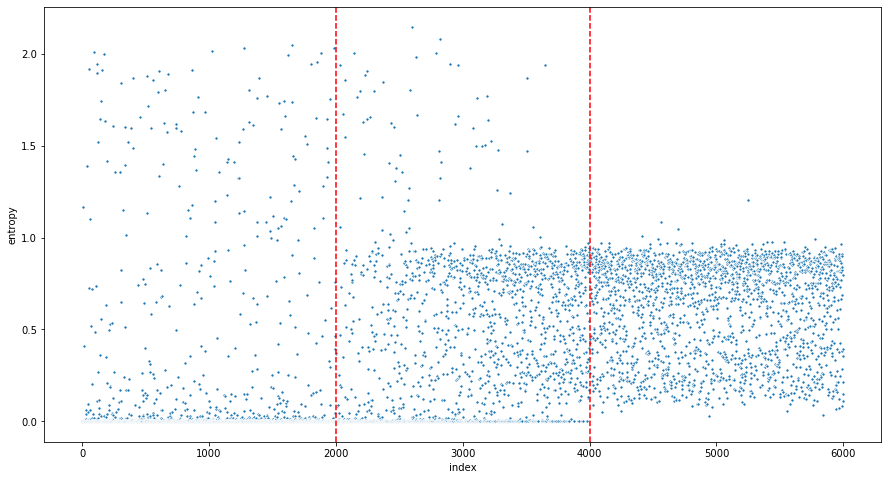

In [281]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="entropy", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(cd_start, c='r', linestyle='dashed')
plt.axvline(cd_full, c='r', linestyle='dashed')